## In this notebook

- EDA.

In [1]:
from pathlib import Path

# data wrangling
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# utils
from utils import (
    get_angle,
    get_combination,
    get_df_players_on_ice_per_sec,
    get_distance_from_goal,
    get_normalized_coordinate,
    get_second,
    get_strength,
    get_time_between_shots,
    get_zone,
)

In [2]:
DATA_FOLDER_PATH = Path("/usr/src/app/data/")

DATA_FILE_NAME_SHOTS = "shots.parquet"
DATA_FILE_NAME_PENALTIES = "penalties.parquet"
DATA_FILE_NAME_PLAYERS = "players.parquet"

OUT_DATA_FILE_NAME_SHOTS = "shots_after_eda.parquet"

## Read data

In [3]:
# shots

df = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME_SHOTS)
df.tail()

,game_id,game_date,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type,shooting_player_id,goalie_in_net_id
600552,2021021132,2022-04-07,55,16,3,REG,19:30,1560,right,missed-shot,622,-69,0,O,16.0,tip-in,8478440,8475831.0
600553,2021021133,2022-04-07,10,25,1,REG,00:51,1551,right,blocked-shot,17,76,-4,D,25.0,None,8479318,NaN
600554,2021021133,2022-04-07,10,25,1,REG,00:58,1551,right,blocked-shot,20,-42,0,D,10.0,None,8473994,NaN
600555,2021021133,2022-04-07,10,25,1,REG,02:20,1551,right,shot-on-goal,35,-34,23,O,25.0,wrist,8480036,8475789.0
600556,2021021133,2022-04-07,10,25,1,REG,03:04,1551,right,shot-on-goal,42,67,27,O,10.0,wrist,8479318,8475809.0


In [4]:
# goals

cols = [
    "game_id", "away_team_id", "home_team_id", "sort_order", "event_owner_team_id", "second", "event_type",
]

df_goals = (
    df
    .assign(
        second=lambda _df: get_second(df=_df)
    )
    .loc[df.event_type == "goal", cols]
    .reset_index(drop=True)
)

df_goals

,game_id,away_team_id,home_team_id,sort_order,event_owner_team_id,second,event_type
0,2023020446,52,26,132,26.0,576,goal
1,2023020446,52,26,175,26.0,749,goal
2,2023020446,52,26,445,52.0,2100,goal
3,2023020446,52,26,557,52.0,2550,goal
4,2023020448,15,4,295,4.0,1334,goal
...,...,...,...,...,...,...,...
32366,2021021130,7,12,686,12.0,3099,goal
32367,2021021130,7,12,788,12.0,3545,goal
32368,2021021131,4,29,205,29.0,906,goal
32369,2021021131,4,29,705,4.0,3415,goal


In [5]:
# penalties

df_penalties = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME_PENALTIES)

# create new features
df_penalties["start_second"] = get_second(df=df_penalties)
df_penalties["end_second"] = df_penalties.start_second + df_penalties.duration.mul(60)
df_penalties["event_type"] = "penalty"

df_penalties.tail()

,game_id,away_team_id,home_team_id,sort_order,event_owner_team_id,served_by_player_id,period,period_type,time_in_period,duration,start_second,end_second,event_type
38741,2020030414,14,8,312,14,8478010.0,2,REG,05:50,2,1550,1670,penalty
38742,2020030414,14,8,410,8,8476469.0,2,REG,14:28,2,2068,2188,penalty
38743,2020030414,14,8,558,8,8475279.0,3,REG,07:42,2,2862,2982,penalty
38744,2020030415,8,14,102,14,8480172.0,1,REG,07:19,2,439,559,penalty
38745,2020030415,8,14,117,14,8478416.0,1,REG,08:15,2,495,615,penalty


## Create features

In [6]:
# season

df["season"] = df.game_id.astype(str).str[:4].astype(int)

In [7]:
# get coordinates related features

df["x_coord_norm"] = get_normalized_coordinate(df=df, coord_type="x")
df["y_coord_norm"] = get_normalized_coordinate(df=df, coord_type="y")
df["distance_from_goal"] = get_distance_from_goal(df=df)
df["angle"] = get_angle(df=df)
df["zone"] = get_zone(df=df)

In [8]:
# get time related features

df["second"] = get_second(df=df)
df["time_between_shots"] = get_time_between_shots(df=df)

In [9]:
%%time

# get penalties related features

# ------ players on ice
dfs = []

for game_id in sorted(df_goals.game_id.unique()):
    df_players_on_ice_per_sec = get_df_players_on_ice_per_sec(
        game_id=game_id, df_penalties=df_penalties, df_goals=df_goals
    )
    dfs.append(df_players_on_ice_per_sec)
    
df_players_on_ice_per_sec_all = pd.concat(dfs, ignore_index=True)


df = (
    pd
    .merge(
        left=df, 
        right=df_players_on_ice_per_sec_all,
        how="left", 
        on=["game_id", "second"],
    )
    # fill the most unusual cases that are not covered above, 
    # e. g. this overtime: https://www.youtube.com/watch?v=dUskPRZr0wY
    .fillna({"away_players_on_ice": 5, "home_players_on_ice": 5})
)

# ------ strength
df["strength"] = get_strength(df=df)

CPU times: user 30.1 s, sys: 2.03 s, total: 32.1 s
Wall time: 32.1 s


In [10]:
# get combinations

df["coords_combination"] = get_combination(df=df, cols=["x_coord_norm", "y_coord_norm"])
df["coords_strength_combination"] = get_combination(df=df, cols=["x_coord_norm", "y_coord_norm", "strength"])

In [11]:
# flags

df["is_empty_net"] = df.goalie_in_net_id.isna().astype(int)
df["is_rebound"] = (
    (df.time_between_shots.le(2))
    & (df.period_type != "SO")
).astype(int)
df["is_goal"] = df.event_type.eq("goal").astype(int)

In [12]:
df.tail()

,game_id,game_date,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type,shooting_player_id,goalie_in_net_id,season,x_coord_norm,y_coord_norm,distance_from_goal,angle,zone,second,time_between_shots,season_type,home_players_in_box,away_players_in_box,home_players_on_ice,away_players_on_ice,strength,coords_combination,coords_strength_combination,is_empty_net,is_rebound,is_goal
600552,2021021132,2022-04-07,55,16,3,REG,19:30,1560,right,missed-shot,622,-69,0,O,16.0,tip-in,8478440,8475831.0,2021,69,0,20.000000,0.000000,high slot,3570,11.0,2,0.0,0.0,5,5,5v5,"69,0","69,0,5v5",0,0,0
600553,2021021133,2022-04-07,10,25,1,REG,00:51,1551,right,blocked-shot,17,76,-4,D,25.0,None,8479318,NaN,2021,-76,4,165.048478,17.102729,neutral,51,NaN,2,0.0,0.0,5,5,5v5,"-76,4","-76,4,5v5",1,0,0
600554,2021021133,2022-04-07,10,25,1,REG,00:58,1551,right,blocked-shot,20,-42,0,D,10.0,None,8473994,NaN,2021,-42,0,131.000000,0.000000,neutral,58,NaN,2,0.0,0.0,5,5,5v5,"-42,0","-42,0,5v5",1,0,0
600555,2021021133,2022-04-07,10,25,1,REG,02:20,1551,right,shot-on-goal,35,-34,23,O,25.0,wrist,8480036,8475789.0,2021,34,-23,59.615434,22.693795,blue line,140,14.0,2,0.0,0.0,5,5,5v5,"34,-23","34,-23,5v5",0,0,0
600556,2021021133,2022-04-07,10,25,1,REG,03:04,1551,right,shot-on-goal,42,67,27,O,10.0,wrist,8479318,8475809.0,2021,67,27,34.828150,50.826342,circle,184,32.0,2,0.0,0.0,5,5,5v5,"67,27","67,27,5v5",0,0,0


## Filters

In [13]:
df = (
    df
    .loc[
        # filter out blocked shots
        (df.event_type != "blocked-shot")

        # filter out shots from team own half of the rink
        & (df.x_coord_norm >= 0)
        
        # filter out rows with missing value in shot_type column
        & (~df.shot_type.isna())
        
        # filter out outliers
        & (df.shot_type != "cradle")
        
        # filter out SO shots
        & (df.period_type != "SO")
    ]
    .reset_index(drop=True)
)

## EDA


Explanatory Data Analysis.

In [14]:
print(f"- number of shots: {len(df):,.0f}")
print(f"- number of seasons: {df.season.nunique()}")
print(f"- number of games: {df.game_id.nunique():,.0f}")
print(f"- number of teams: {df.event_owner_team_id.nunique():,.0f}")
print(f"- number of shooting players: {df.shooting_player_id.nunique():,.0f}")
print(f"- number of goaltenders: {df.goalie_in_net_id.nunique():,.0f}")

- number of shots: 435,186
- number of seasons: 4
- number of games: 5,153
- number of teams: 32
- number of shooting players: 1,322
- number of goaltenders: 159


### Feature distribution

Analyze the distribution of features.

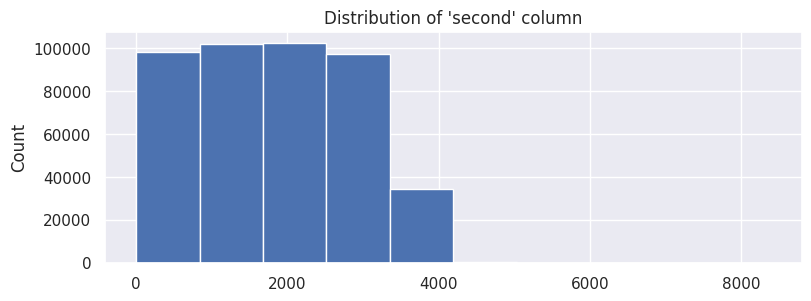

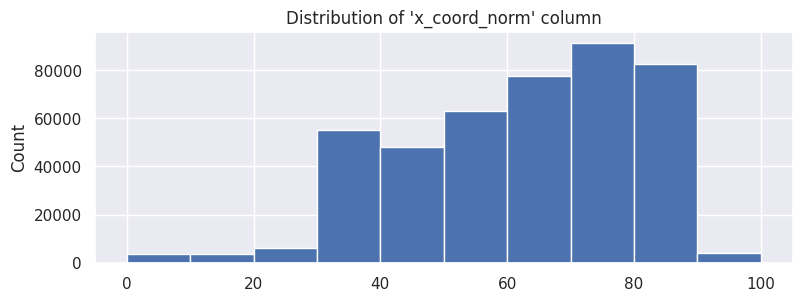

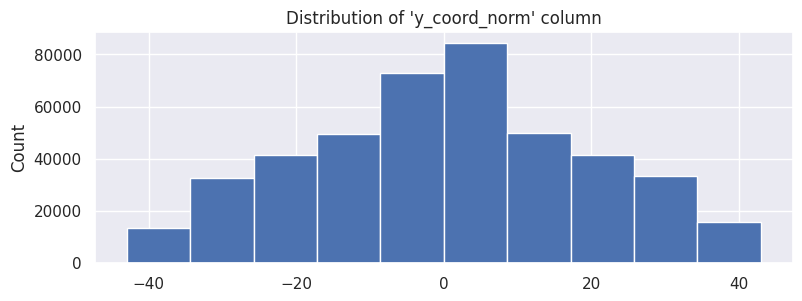

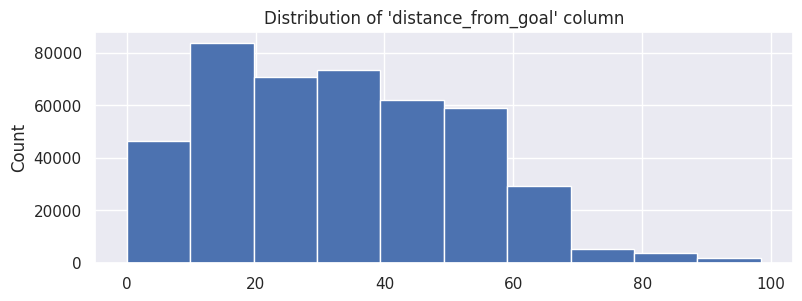

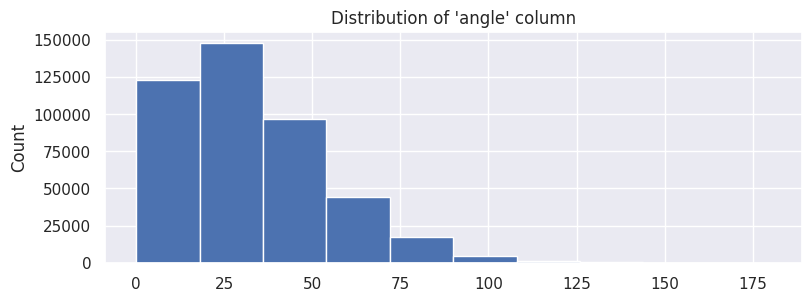

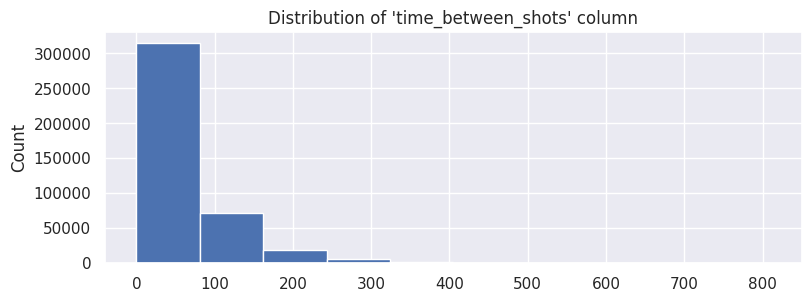

In [15]:
def plot_numerical_feature_dist(col: str) -> None:
    ax = (
        df[col]
        .plot(
            kind="hist", 
            bins=10,
            figsize=(9, 3),
        )
    )
    
    ax.set_xlabel("")
    ax.set_ylabel("Count")

    ax.set_title(f"Distribution of '{col}' column")
    plt.show()
    

for col in ["second", "x_coord_norm", "y_coord_norm", "distance_from_goal", "angle", "time_between_shots"]:
    plot_numerical_feature_dist(col=col)

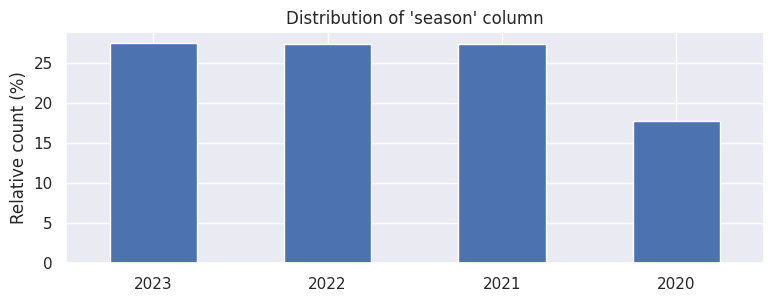

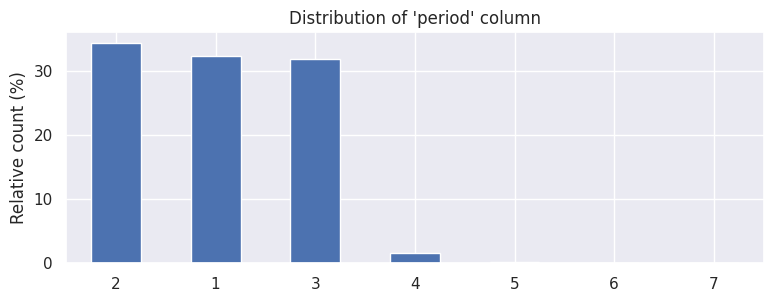

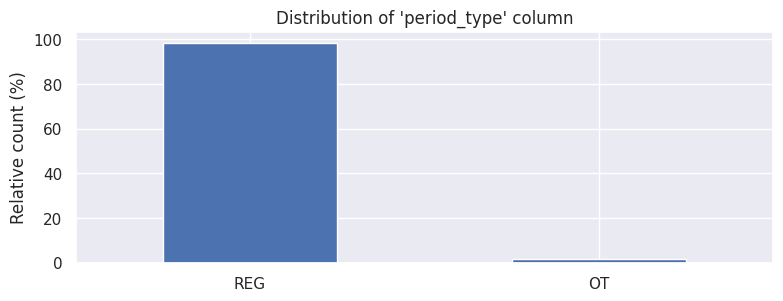

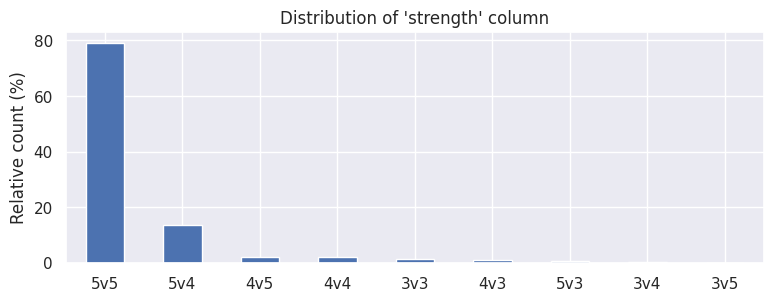

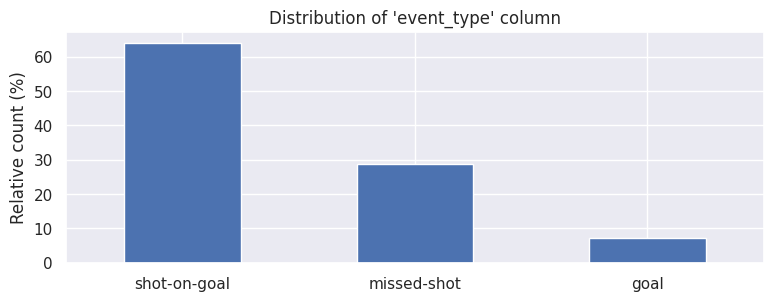

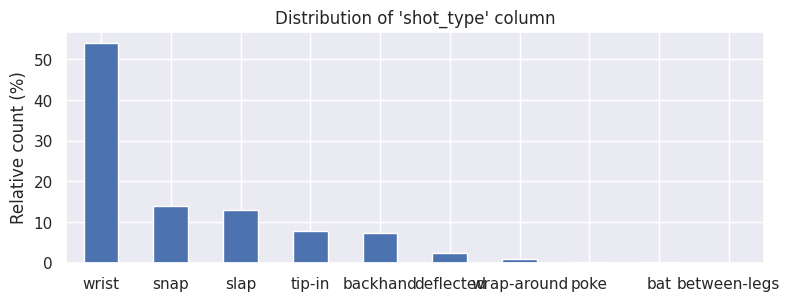

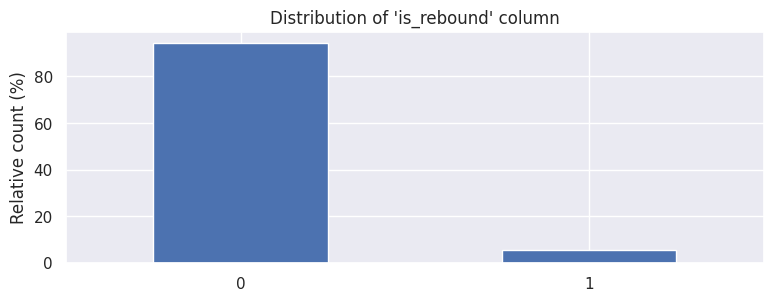

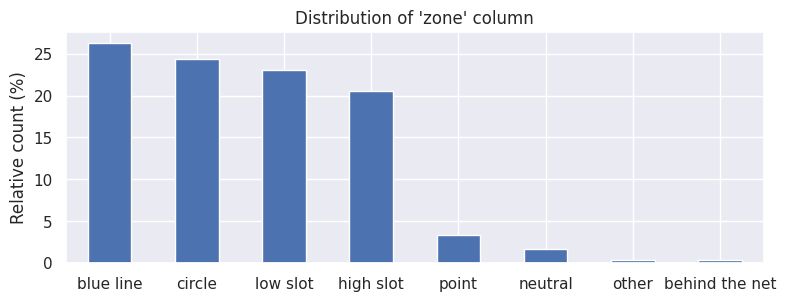

In [16]:
def plot_categorical_feature_dist(col: str) -> None:
    rot = 45 if df[col].nunique() > 10 else 0
    
    ax = (
        df[col]
        .value_counts(normalize=True)
        .mul(100)
        .plot(
            kind="bar", 
            rot=rot,
            figsize=(9, 3),
        )
    )

    ax.set_xlabel("")
    ax.set_ylabel("Relative count (%)")

    ax.set_title(f"Distribution of '{col}' column")
    plt.show()


for col in ["season", "period", "period_type", "strength", "event_type", "shot_type", "is_rebound", "zone"]:
    plot_categorical_feature_dist(col=col)

### Shots location distribution

Plot the distribution of shot locations on the rink to understand where most shots are taken.

In [17]:
def plot_heatmap(df: pd.DataFrame, title: str = "KDE plot") -> None:
    # read rink diagram
    img = plt.imread("/usr/src/app/images/half_rink_diagram.jpg")
    plt.imshow(img, zorder=0, extent=[-3, 106, -45, 45], alpha=0.75)
    
    # create KDE plot
    ax = sns.kdeplot(
        data=df,
        x="x_coord_norm", 
        y="y_coord_norm", 
        cmap=sns.color_palette("light:r", as_cmap=True),
        fill=True,
        clip=((0, 88), (-43, 43)),
        cut=10,
        alpha=0.9,
        thresh=0.2,
        levels=7,
        bw_adjust=0.4,
    )

    # hide axis
    ax.axis("off")

    # add title
    ax.set_title(title)

    plt.show()

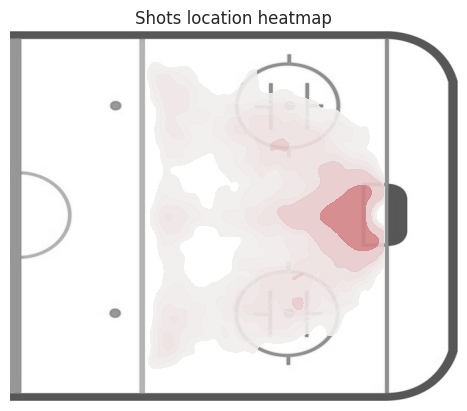

In [18]:
# shot heatmap for all the shots

plot_heatmap(df=df.sample(frac=0.1), title="Shots location heatmap")

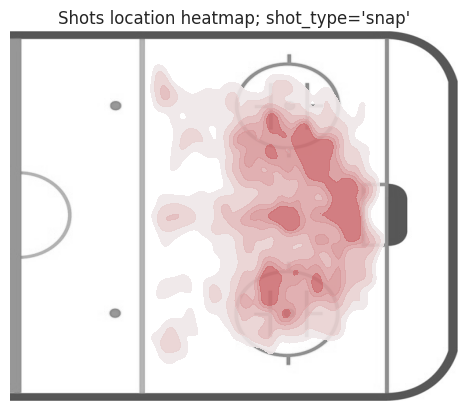

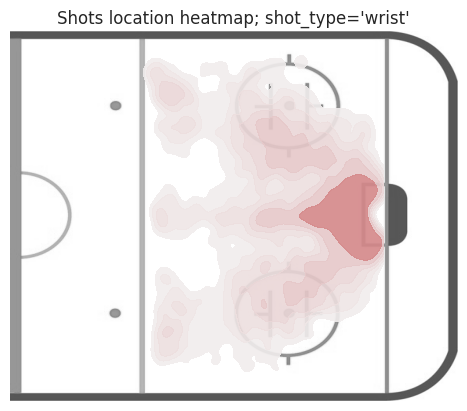

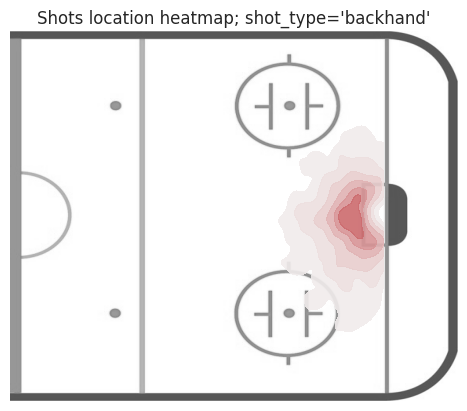

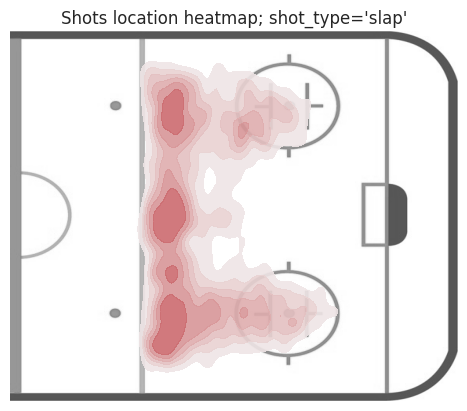

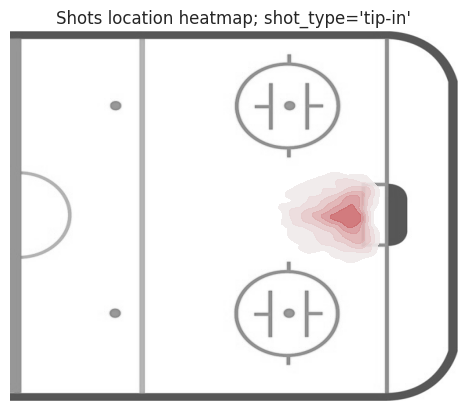

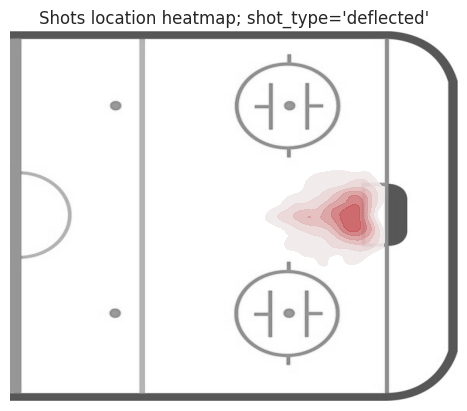

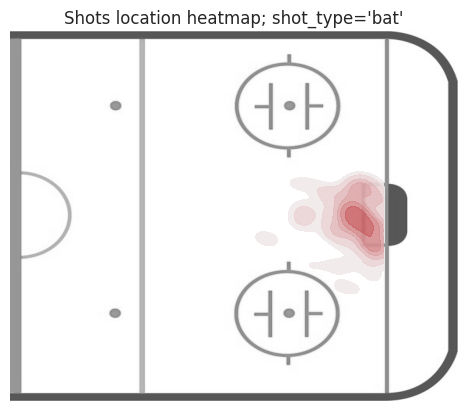

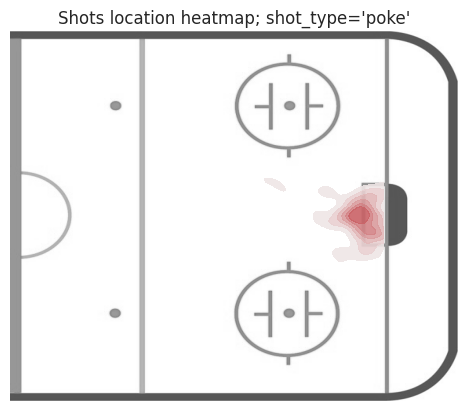

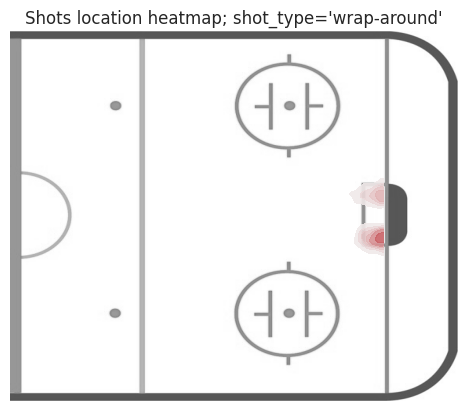

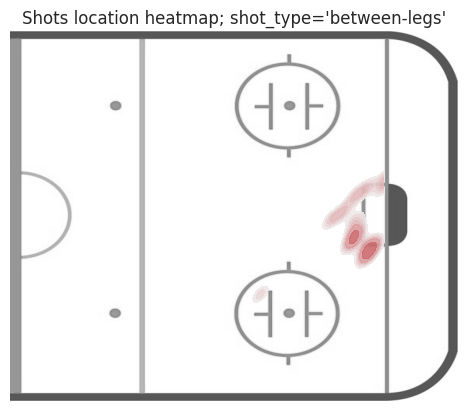

In [19]:
# shot heatmap by shot type 

for shot_type in df.shot_type.unique():
    plot_heatmap(
        df=df.loc[df.shot_type == shot_type].sample(frac=0.1), 
        title=f"Shots location heatmap; {shot_type=}"
    )

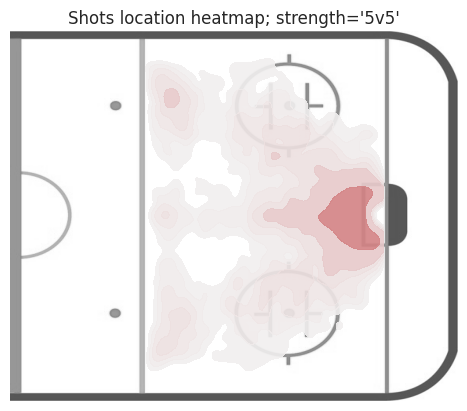

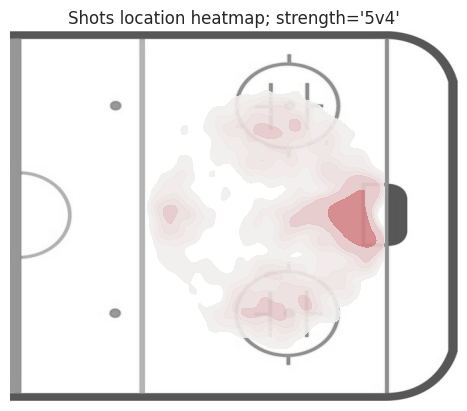

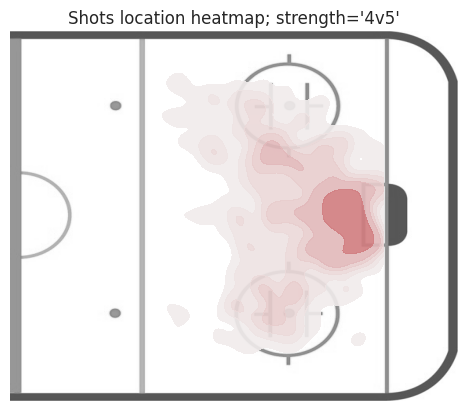

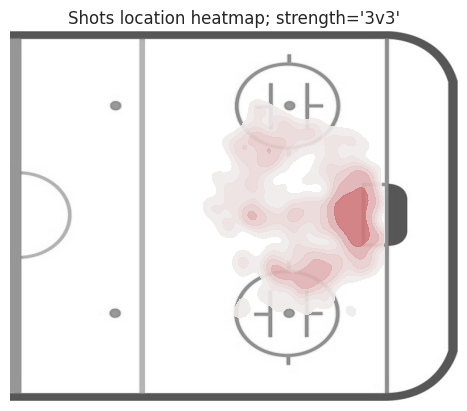

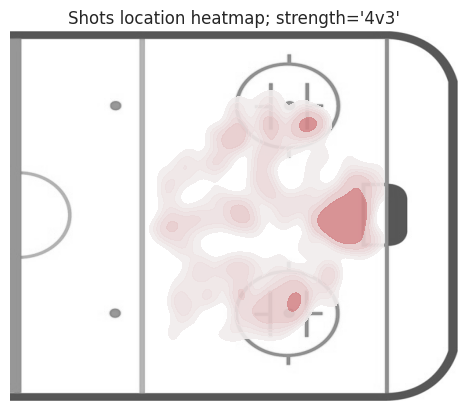

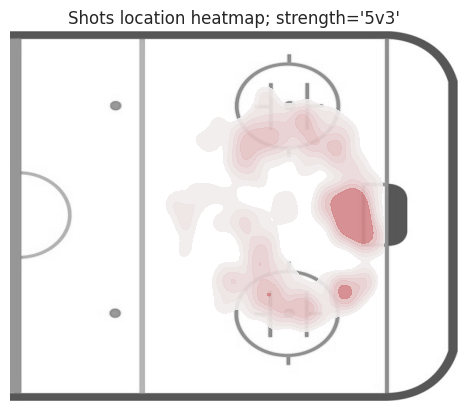

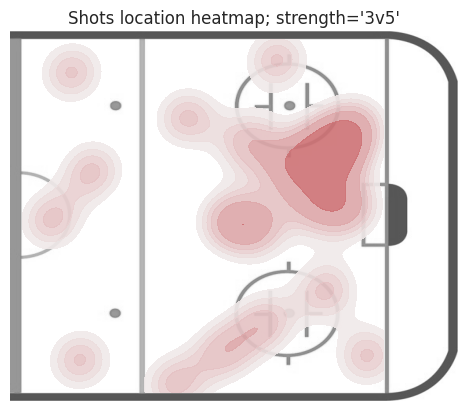

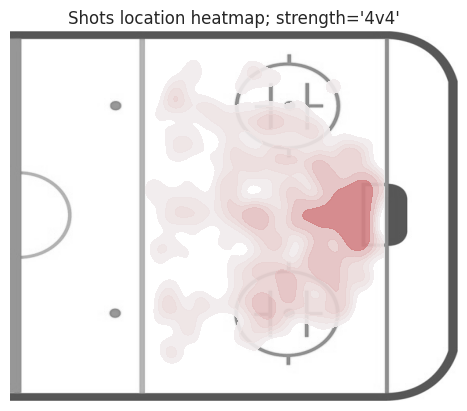

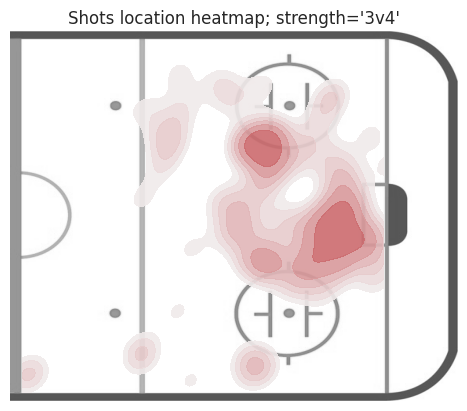

In [20]:
# shot heatmap by strength

for strength in df.strength.unique():
    plot_heatmap(
        df=df.loc[df.strength == strength].sample(frac=0.1), 
        title=f"Shots location heatmap; {strength=}"
    )

### Outcome analysis

Analyze the distribution of shot outcomes (goals pct) relative to different features.

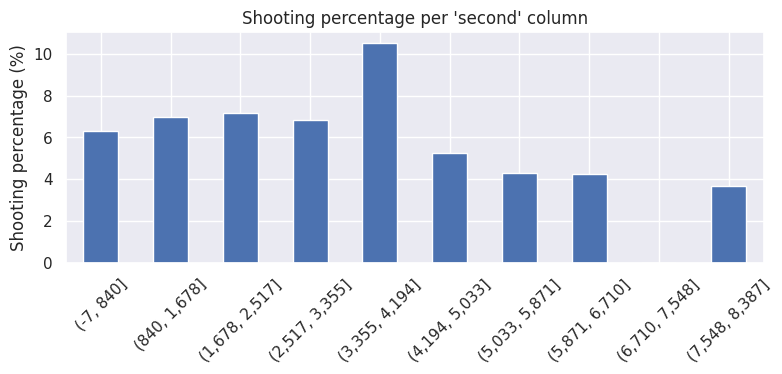

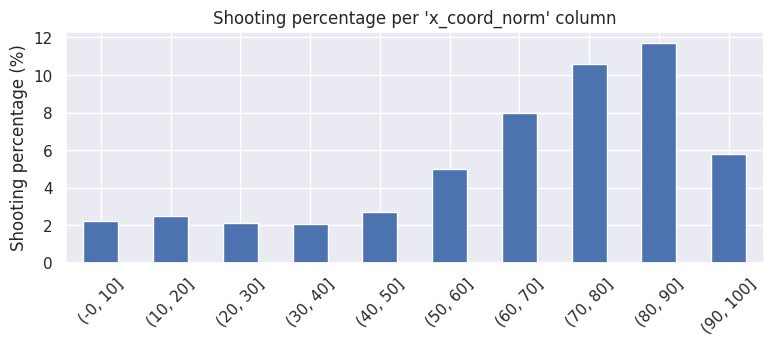

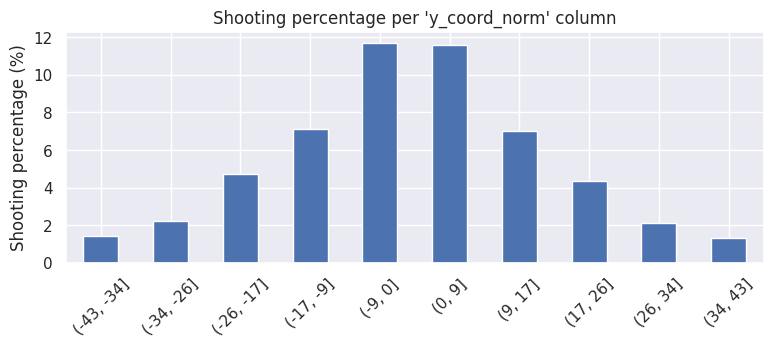

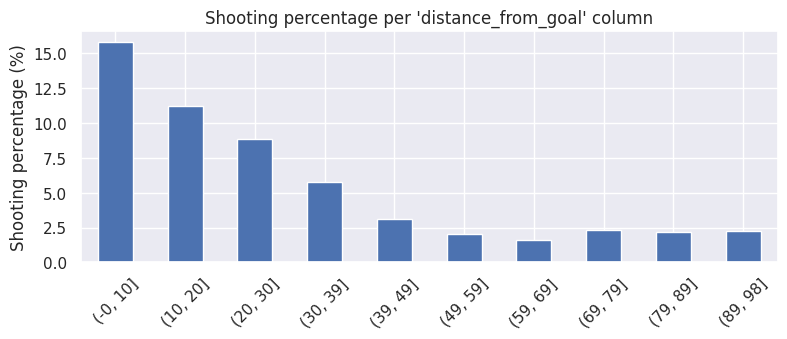

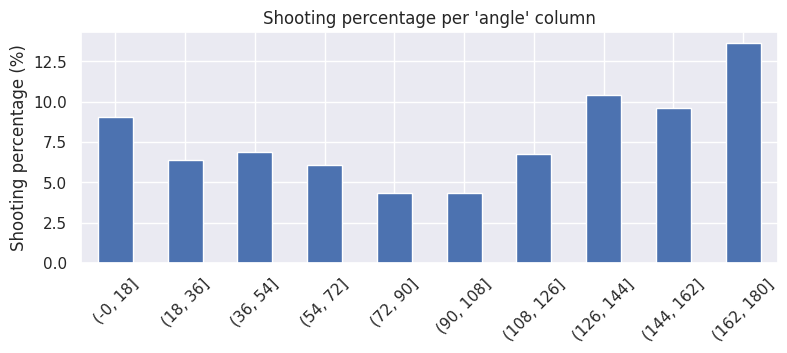

In [21]:
def plot_shooting_pct_per_numerical_feature(col: str, bins: int = 10) -> None:
    _, edges = pd.cut(df[col].dropna(), bins=bins, retbins=True)
    labels = [f"({edges[i]:,.0f}, {edges[i + 1]:,.0f}]" for i in range(bins)]
    
    ax = (
        df
        .groupby(by=pd.cut(df[col].dropna(), bins=bins, labels=labels, include_lowest=True), observed=False)
        .is_goal
        .mean()
        .mul(100)
        .plot(
            kind="bar", 
            rot=45,
            figsize=(9, 3),
        )
    )

    ax.set_xlabel("")
    ax.set_ylabel("Shooting percentage (%)")

    ax.set_title(f"Shooting percentage per '{col}' column")
    plt.show()
    

for col in ["second", "x_coord_norm", "y_coord_norm", "distance_from_goal", "angle"]:
    plot_shooting_pct_per_numerical_feature(col=col)

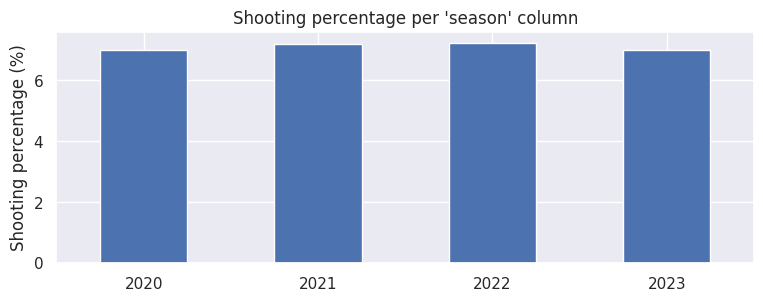

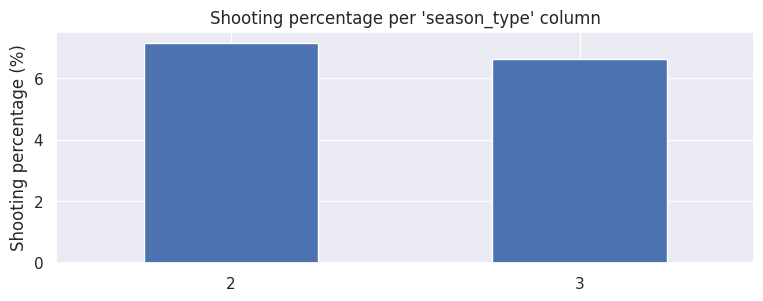

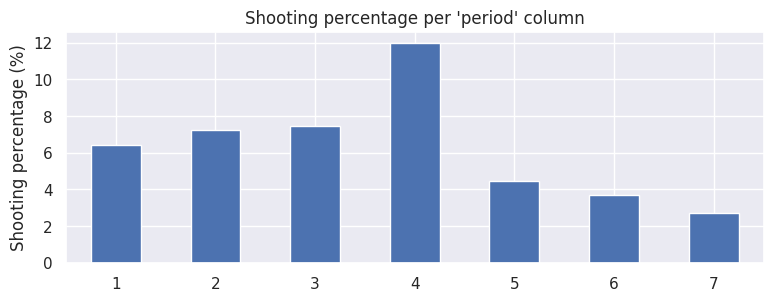

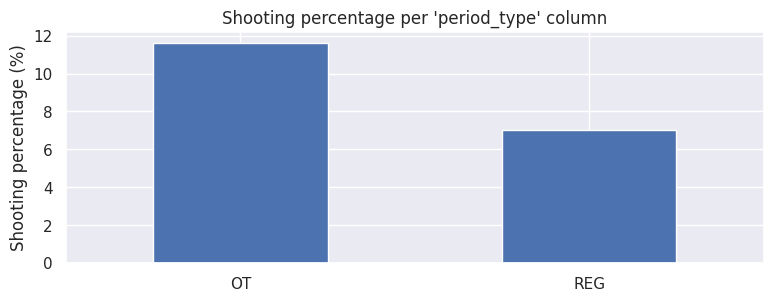

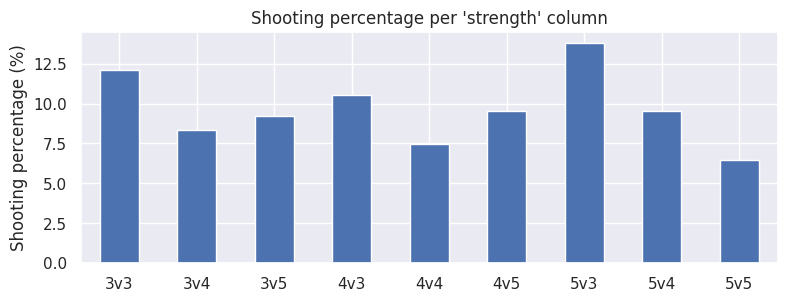

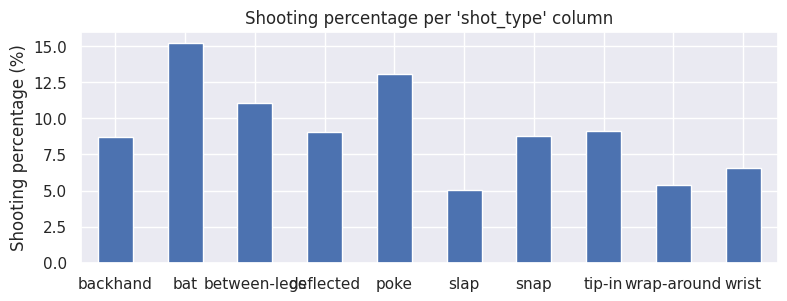

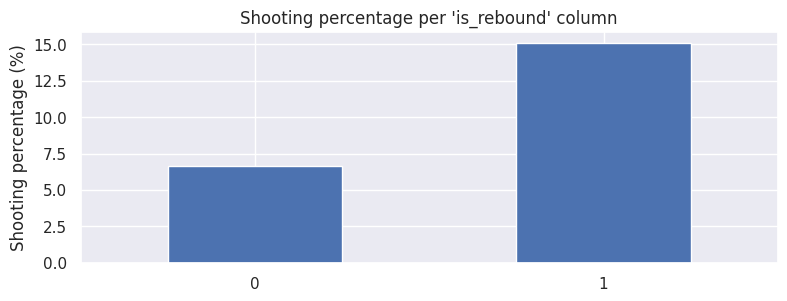

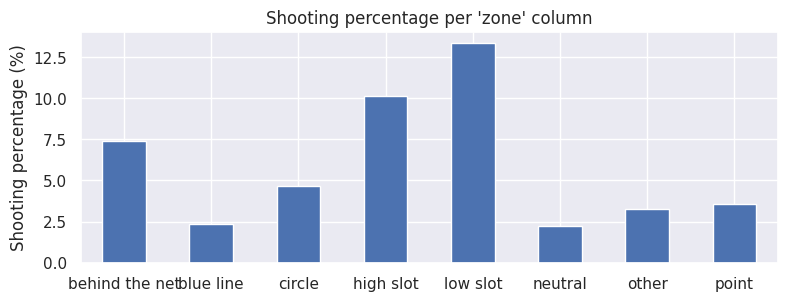

In [22]:
def plot_shooting_pct_per_categorical_feature(col: str) -> None:
    rot = 45 if df[col].nunique() > 10 else 0
    
    ax = (
        df
        .groupby(by=[col])
        .is_goal
        .mean()
        .mul(100)
        .plot(
            kind="bar", 
            rot=rot,
            figsize=(9, 3),
        )
    )

    ax.set_xlabel("")
    ax.set_ylabel("Shooting percentage (%)")

    ax.set_title(f"Shooting percentage per '{col}' column")
    plt.show()
    

for col in ["season", "season_type", "period", "period_type", "strength", "shot_type", "is_rebound", "zone"]:
    plot_shooting_pct_per_categorical_feature(col=col)

## Save data

In [23]:
df.to_parquet(DATA_FOLDER_PATH / OUT_DATA_FILE_NAME_SHOTS)

## Results

- Finished EDA.